# Anggota Tim :
- Ni Made Ayu Aghata Widya Lestari (1201194075)
- Lutfi Muhammad (1201190253)
- Kartika Salsabilla Wulandari (1201194051)
- Meyliza Gusandi (1201174281)

# Setup
Menggunakan module numpy dengan alasan kecepatan dalam pemrosesan list dan juga support vector, selain itu menggunakan module matplotlib untuk membuat visualisasi dari data yang dihasilkan

In [2]:
!pip install --upgrade pip
!pip install numpy
!pip install matplotlib

In [3]:
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline 
%matplotlib InlineBackend.figure_format = 'svg'
plt.style.use("seaborn")
np.random.seed(42) # fungsi ini supaya nomor random yang di generate tidak selalu berubah ketika di eksesuki (memudahkan debug)


UsageError: unrecognized arguments: = 'svg'


# Membuat Representasi
TSP membutuhkan data kota dan juga jarak antar kota, disini dicoba terlebih dahulu untuk merepresentasikan secara eksplisit kota dan jarak antar kota. Represntasi antara jarak antar kota <sub>_i_</sub> dan <sub>_j_</sub> sehingga _A_<sub>_ij_</sub> menyatakan jarak antara kedua kota.

keterangan : 
_cities_ = kota
_adjacency_mat_ = matriks jarak antar kota

In [4]:
cities = [0, 1, 2, 3, 4]

adjacency_mat = np.asarray(
    [
        [0.00, 28.02, 17.12, 27.46, 46.07],
        [28.02, 0.00, 34.00, 25.55, 25.55],
        [17.12, 34.00, 0.00, 18.03, 57.38],
        [27.46, 25.55, 18.03, 0.00, 51.11],
        [46.07, 25.55, 57.38, 51.11, 0.00],
    ]
)


# Implementasi
Definiskan class yang merepresentasikan Populasi yang didalam nya terdapat informasi spesifik tentang generasi populasi pada class tersebut. Spesifiknya ada informasi tentang :
- _bag_ : representasi dari seluruh populasi (kantong populasi)
- _parents_ : generasi terbaik yang terpilih dari populasi tersebut (atau induk)
- _score_ : menyimpan nilai dari kromosom terbaik dari populasi
- _best_ : menyimpan kromosom terbaik
- _adjacency_mat_ : digunkan untuk menghitung jarak antar kota dalam konteks TSP

In [5]:
class Population():
    def __init__(self, bag, adjacency_mat):
        self.bag = bag
        self.parents = []
        self.score = 0
        self.best = None
        self.adjacency_mat = adjacency_mat

## Fungsi _Generate Random_ Populasi (Inisialisasi Populasi)

In [6]:
def init_population(cities, adjacency_mat, n_population):
        return Population(
            np.asarray([np.random.permutation(cities) for _ in range(n_population)]),
            adjacency_mat
        )

## Melihat isi dari _Generate Dummy_ Populasi
Memastikan fungsi berjalan semestinya

In [7]:
pop = init_population(cities, adjacency_mat, 5)
pop.bag

array([[3, 4, 1, 0, 2],
       [0, 3, 1, 2, 4],
       [4, 1, 0, 2, 3],
       [2, 1, 4, 0, 3],
       [4, 0, 1, 3, 2]])

# Fitness
Sekarang kita membutuhkan beberapa fungsi yang akan menentukan _fitness_ dari sebuah kromosom. Dalam konteks TSP, _fitness_ didefinisikan dalam istilah : semakin pendek jarak total, semakin _fit_ dan semakin unggul kromosom. Semua informasi jarak yang dibutuhkan akan disimpan dalam `self.adjacency_mat`. Kita dapat menghitung jumlah semua jarak antara dua kota yang berdekatan dalam urutan kromosom.

In [8]:
def fitness(self, chromosome):
    return sum(
        [
            self.adjacency_mat[chromosome[i], chromosome[i + 1]]
            for i in range(len(chromosome) - 1)
        ]
    )

Population.fitness = fitness

# Seleksi
Selanjutnya, mengevaluasi populasi. Sederhananya, evaluasi berarti menghitung kesesuaian setiap kromosom dalam populasi total, menentukan siapa yang terbaik, menyimpan informasi skor, dan mengembalikan beberapa vektor probabilitas yang setiap elemennya mewakili probabilitas bahwa elemen ke-i dalam kantong populasi dipilih sebagai _parents_/induk. Kami menerapkan beberapa pra-pemrosesan dasar untuk memastikan bahwa kromosom dengan kinerja terburuk sama sekali tidak memiliki peluang untuk dipilih.

In [9]:
def evaluate(self):
    distances = np.asarray(
        [self.fitness(chromosome) for chromosome in self.bag]
    )
    self.score = np.min(distances)
    self.best = self.bag[distances.tolist().index(self.score)]
    self.parents.append(self.best)
    if False in (distances[0] == distances):
        distances = np.max(distances) - distances
    return distances / np.sum(distances)

Population.evaluate = evaluate

Saat memanggil `pop.evaluate()`, kita mendapatkan vektor probabilitas seperti yang diharapkan.

In [10]:
pop.evaluate()

array([0.19425574, 0.        , 0.478717  , 0.09725686, 0.2297704 ])

Saat kita memanggil `pop.best`, maka hasil akan mengurutkan kromosom terbaik.

In [11]:
pop.best

array([4, 1, 0, 2, 3])

In [12]:
from IPython.display import Markdown as md
md(f"kita juga dapat melihat skor kromosom terbaik. Dalam hal ini, jarak dikatakan {pop.score}. Perhatikan bahwa semakin rendah skornya, semakin baik, karena skor ini mewakili total jarak yang harus ditempuh seorang penjual untuk mengunjungi semua kota dalam kasus TSP.")

kita juga dapat melihat skor kromosom terbaik. Dalam hal ini, jarak dikatakan 88.72. Perhatikan bahwa semakin rendah skornya, semakin baik, karena skor ini mewakili total jarak yang harus ditempuh seorang penjual untuk mengunjungi semua kota dalam kasus TSP.

In [13]:
pop.score

88.72

# Proses Memilik _Parents_ Untuk Generasi Selanjutnya
Sekarang, kita akan memilih k : jumlah _parents_ untuk menjadi basis generasi berikutnya. Di sini, kami menggunakan model _roulette_ sederhana, di mana kami membandingkan nilai vektor probabilitas dan nomor acak yang diambil dari distribusi seragam. Jika nilai vektor probabilitas lebih tinggi, kromosom yang sesuai ditambahkan ke `self.parents`. Kami mengulangi proses ini sampai kami memiliki k _parents_.

In [14]:
def select(self, k =4):
    fit = self.evaluate()
    while len(self.parents) < k:
        idx = np.random.randint(0, len(fit))
        if fit[idx] > np.random.rand():
            self.parents.append(self.bag[idx])
    self.parents = np.asarray(self.parents)

Population.select = select

In [15]:
pop.select()

Seperti yang diharapkan, kami mendapatkan 4 _parents_ setelah memilih _parents_ melalui `pop.select()`

In [16]:
pop.parents

array([[4, 1, 0, 2, 3],
       [4, 1, 0, 2, 3],
       [2, 1, 4, 0, 3],
       [4, 0, 1, 3, 2]])

# _Swap_
kami menggunakan mutasi swap dan crossover sederhana. Seperti namanya, swap hanya melibatkan pertukaran dua elemen kromosom. Misalnya, jika kita memiliki [a, b, c], kita dapat menukar dua elemen pertama menjadi [b, a, c].

In [17]:
def swap(chromosome):
    a, b = np.random.choice(len(chromosome), 2)
    chromosome[a], chromosome[b] = (
        chromosome[b],
        chromosome[a],
    )
    return chromosome

Masalah dengan mutasi swap, adalah bahwa swapping adalah proses yang sangat mengganggu dalam konteks TSP. Karena setiap kromosom mengkodekan urutan di mana seorang salesman harus mengunjungi setiap kota, bertukar dua kota dapat sangat mempengaruhi skor kebugaran akhir dari kromosom yang bermutasi. Oleh karena itu, kami juga menggunakan bentuk mutasi lain, yang dikenal sebagai crossover.

# _Cross-Over_
kita ambil dua _parents_ kemudian _slice_ sebagian kromosom dari satu _parents_, dan mengisi sisa slot dengan _parents_ lainnya. Saat mengisi sisa slot, kita perlu memastikan bahwa tidak ada duplikat dalam kromosom. Mari kita lihat sebuah contoh. Bayangkan _parents_ satu memiliki `[a, b, c, d, e]` dan yang lainnya memiliki `[b, a, e, c, d]`. Katakanlah kita _slice_ bagian acak dari _parents_ pertama memberi kita `[None, b, c, None, None]`. Kemudian, kami mengisi sisa indeks kosong dengan _parents_ lainnya, dengan memperhatikan urutan kemunculan elemen. Dalam hal ini, kita akan berakhir dengan `[a, b, c, e, d]`.

In [18]:
def crossover(self, p_cross=0.1):
    children = []
    count, size = self.parents.shape
    for _ in range(len(self.bag)):
        if np.random.rand() > p_cross:
            children.append(
                list(self.parents[np.random.randint(count, size=1)[0]])
            )
        else:
            parent1, parent2 = self.parents[
                np.random.randint(count, size=2), :
            ]
            idx = np.random.choice(range(size), size=2, replace=False)
            start, end = min(idx), max(idx)
            child = [None] * size
            for i in range(start, end + 1, 1):
                child[i] = parent1[i]
            pointer = 0
            for i in range(size):
                if child[i] is None:
                    while parent2[pointer] in child:
                        pointer += 1
                    child[i] = parent2[pointer]
            children.append(child)
    return children

Population.crossover = crossover

# _Mutation_
Sekarang, kami memasukkan mutasi _crossover_ menjadi satu fungsi yang dapat dipanggil sehingga kami melakukan setiap mutasi sesuai dengan beberapa ambang batas / _threshold_ yang ditentukan.

In [19]:
def mutate(self, p_cross=0.1, p_mut=0.1):
    next_bag = []
    children = self.crossover(p_cross)
    for child in children:
        if np.random.rand() < p_mut:
            next_bag.append(swap(child))
        else:
            next_bag.append(child)
    return next_bag

Population.mutate = mutate

Ketika menjalankan `pop.mutate()` kita akan melihat kantong populasi untuk generasi berikutnya

In [20]:
pop.mutate()

[[2, 1, 4, 0, 3],
 [2, 1, 4, 0, 3],
 [2, 1, 4, 0, 3],
 [4, 0, 1, 3, 2],
 [4, 1, 0, 2, 3]]

Sekarang saatnya untuk menyatukan semua fungsi ditambah beberapa parameter tambahan seperti _print_interval_, jalankan simulasi pemilihan populasi dan mutasi dengan _n_iter_ generasi. Bagian penting pada bagian ini adalah `children = pop.mutate(p_cross, p_mut)` dan `pop = Population(children, pop.adjacency_mat)`. Pada dasarnya, kita memperoleh anak-anak dari mutasi dan meneruskannya sebagai kantong populasi generasi berikutnya dalam konstruktor Populasi.

In [21]:
def genetic_algorithm(cities, adjacency_mat, n_population=5, n_iter=20, selectivity=0.15, p_cross=0.5, p_mut=0.1, print_interval=100, return_history=False, verbose=False):
    pop = init_population(cities, adjacency_mat, n_population)
    best = pop.best
    score = float("inf")
    history = []
    for i in range(n_iter):
        pop.select(n_population * selectivity)
        history.append(pop.score)
        if verbose:
            print(f"Generation {i}: {pop.score}")
        elif i % print_interval == 0:
            print(f"Generation {i}: {pop.score}")
        if pop.score < score:
            best = pop.best
            score = pop.score
        children = pop.mutate(p_cross, p_mut)
        pop = Population(children, pop.adjacency_mat)
    if return_history:
        return best, history
    return best

Sekarang mari kita uji pada contoh TSP kita selama 20 generasi. Seiring berlalunya generasi, skor _fitness_ semakin membaik.

In [22]:
genetic_algorithm(cities, adjacency_mat, verbose=True)

Generation 0: 138.41
Generation 1: 138.41
Generation 2: 138.41
Generation 3: 138.41
Generation 4: 138.41
Generation 5: 138.41
Generation 6: 135.94
Generation 7: 135.94
Generation 8: 127.78
Generation 9: 127.78
Generation 10: 127.78
Generation 11: 127.78
Generation 12: 127.78
Generation 13: 127.78
Generation 14: 127.78
Generation 15: 127.78
Generation 16: 121.8
Generation 17: 121.24
Generation 18: 121.24
Generation 19: 121.24


[2, 0, 3, 4, 1]

Mari kita coba menjalankan uji coba TSP yaitu sebanyak 100 generasi. Untuk kejelasan, mari kita juga tampilkan plot kemajuan algoritma genetika kita dengan menyetel _return_history_ ke _True_

Generation 0: 88.72
Generation 20: 86.25
Generation 40: 86.25
Generation 60: 86.25
Generation 80: 86.25


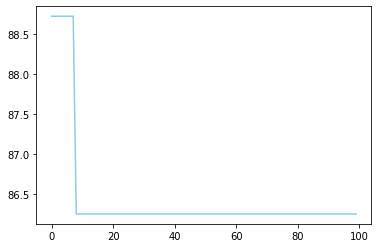

[4, 1, 3, 2, 0]


In [23]:
best, history = genetic_algorithm(cities, adjacency_mat, n_iter=100, verbose=False, print_interval=20, return_history=True)

plt.plot(range(len(history)), history, color="skyblue")
plt.show()
print(best)

In [24]:
from IPython.display import Markdown as md
md(f"Setelah sekitar 10~80 iterasi, sepertinya algoritma telah konvergen ke minimum, nilainya tetap di nilai { min(history) }. Lalu hasilnya optimal rute dengan urutan { best }")

Setelah sekitar 10~80 iterasi, sepertinya algoritma telah konvergen ke minimum, nilainya tetap di nilai 86.25. Lalu hasilnya optimal rute dengan urutan [4, 1, 3, 2, 0]

# Penerapan TSP dengan _random_ 10 kota dan _random_ jarak antar 10 kota


Buat fungsi untuk generate kordinat kota secara random, dengan range random 1-50 (n_cities * factor) untuk menghasilkan batas / _thresold_ 50

In [25]:
def generate_cities(n_cities, factor=5):
    return np.random.rand(n_cities, 2) * n_cities * factor

_generate_cities()_ : generate _n_cities_ dengan random kordinat kota dalam bentuk array numpy. Sekarang, kita membutuhkan beberapa fungsi yang akan membuat matriks jarak antar kota berdasarkan kordinat kota.

In [26]:
def make_mat(coordinates):
    res = [
        [get_distance(city1, city2) for city2 in coordinates]
        for city1 in coordinates
    ]
    return np.asarray(res)

def get_distance(city1, city2):
    return np.sqrt((cities[0] - city2[0])**2 + (city1[1] - city2[1])**2)

lakukan pemeriksaan terhadap fungsi dengan memanggil fungsi _make_mat()_ sehingga memastikan bahwa _generate_cities()_ memang membuat koordinat kota seperti yang diharapkan. Maka akan kita coba mengirimkan kordinat dummy

In [27]:
test_coords = [[0, 0], [0,1], [1,1], [1,0]]
make_mat(test_coords)

array([[0.        , 1.        , 1.41421356, 1.        ],
       [1.        , 0.        , 1.        , 1.41421356],
       [1.        , 0.        , 1.        , 1.41421356],
       [0.        , 1.        , 1.41421356, 1.        ]])

Generate random 10 kota dan kembalikan dalam bentuk jarak antar kota dari 10 kota

In [28]:
generate_cities(10)

array([[ 5.44294063, 20.69822607],
       [14.21749083,  0.13148335],
       [ 2.37368268,  5.3538595 ],
       [19.52275887, 25.39890955],
       [16.33759306, 46.12138607],
       [10.18224593, 37.79855298],
       [13.77135002, 25.39912342],
       [24.30325865, 15.24563009],
       [38.19629309, 35.85249824],
       [15.73733943, 31.48199589]])

# Percobaan Menemukan Jalur Optimal
Pada tahp ini, fungsi generate random kordinat kota sudah berhasil dilakukan, selanjutnya kita menggunakan algoritma genetika untuk menemukan jalur optimal menggunakan fungsi _genetic_algorithm()_ dengan parameter yang disesuaikan

Generation 0: 245.10642696858295
Generation 1: 237.99811235769164
Generation 2: 226.66411287946917
Generation 3: 226.66411287946917
Generation 4: 222.3706830742816
Generation 5: 222.3706830742816
Generation 6: 222.3706830742816
Generation 7: 222.3706830742816
Generation 8: 222.3706830742816
Generation 9: 222.3706830742816
Generation 10: 222.3706830742816
Generation 11: 221.2346273587014
Generation 12: 221.2346273587014
Generation 13: 220.55201545074954
Generation 14: 220.55201545074954
Generation 15: 220.55201545074954
Generation 16: 220.55201545074954
Generation 17: 217.32200724765713
Generation 18: 217.32200724765713
Generation 19: 217.32200724765713
Generation 20: 217.32200724765713
Generation 21: 217.32200724765713
Generation 22: 217.32200724765713
Generation 23: 217.32200724765713
Generation 24: 217.32200724765713
Generation 25: 217.22714955258002
Generation 26: 217.22714955258002
Generation 27: 216.64880609891534
Generation 28: 216.64880609891534
Generation 29: 216.64880609891534

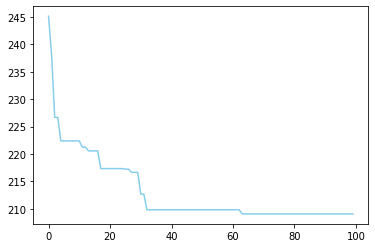

[9, 1, 2, 4, 8, 5, 6, 3, 7, 0]


In [29]:
cities = range(10) # masukan jumlah kota disini, minimal 10 kota
city_coordinates = generate_cities(len(cities))
adjacency_mat = make_mat(city_coordinates)
best, history = genetic_algorithm(
    cities, adjacency_mat, n_population=20, n_iter=100, verbose=True, return_history=True
) # sesuaikan jumlah pupulasi, jumlah iterasi / generasi (jika kurang optimal), dan interval print data setiap 5 generasi
plt.plot(range(len(history)), history, color="skyblue")
plt.show() # tampilkan plot histogram dari peforma optimal setiap iterasi generasi
print(best) # tampilkan jalur terbaik perjalanan yang dapat dilakukan

Menampilkan path / jalur optimal yang dapat di lalui dalam bentuk histogram

In [30]:
def print_path(best, city_coordinates):
    points = city_coordinates[best]
    x, y = zip(*points)
    plt.plot(x,y, color="skyblue", marker="o")

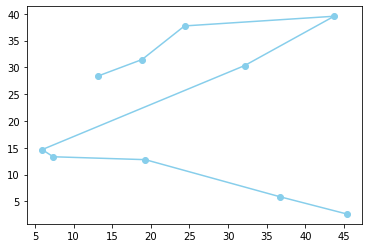

In [31]:
print_path(best, city_coordinates)

# Kesimpulan

In [32]:
print(f"Kordinat dari {len(cities)} kota : \n {city_coordinates} \n Dengan jarak antar kota : \n {adjacency_mat} \n Memiliki nilai jarak optimal : {min(history)} dengan jalur / path : {best}")

Kordinat dari 10 kota : 
 [[13.14268518 28.36726069]
 [36.71491683  5.84419037]
 [19.28730074 12.77148866]
 [24.35919958 37.7289199 ]
 [ 7.36587308 13.31292438]
 [32.13782148 30.33035551]
 [43.71003267 39.53659201]
 [18.86534835 31.45787386]
 [ 5.94269794 14.64927472]
 [45.31833235  2.64531164]] 
 Dengan jarak antar kota : 
 [[13.14268518 43.07288956 24.80379155 26.09619258 16.75974726 32.19772213
  45.11453112 19.1168318  14.94987619 52.10921137]
 [26.07717144 36.71491683 20.49359488 40.12488731 10.48990343 40.40311687
  55.18826763 31.81135254 10.62286069 45.43109147]
 [20.39505526 37.36271644 19.28730074 34.87468966  7.38574566 36.62176094
  51.25366049 26.55338699  6.23231412 46.43587738]
 [16.13601056 48.62736982 31.5416129  24.35919958 25.50288069 32.97845243
  43.74739575 19.88032663 23.83245016 57.31152428]
 [19.98407405 37.46688012 19.29489887 34.48929459  7.36587308 36.36526546
  50.97300953 26.17518978  6.09109933 46.55694587]
 [13.28848806 44.13113868 26.08282529 25.4579920